In [1]:
## This should be transform into independent .py files.
## One file to generate the variation on experimental composition to realize, another for the pipeline transformation
## of the data to the final EXP110 file.


# Generate Experimental Datasets
 This is made in two steps : 
- generate the combinations of carbon source to be tested experimentally
- use the experimental result to extract growth rate from raw plate reader data

### Generate combinations


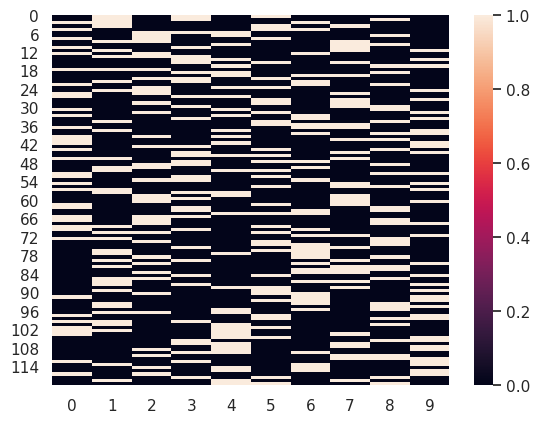

In [2]:
import os
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


# The itertools library is not the original author choice so the composition in not the same.
def binary_full_factorial_design(lenght, number_of_ones, seed):
    """Return a numpy array with all the combinatorial possibilities of list 
    of zero and 1 of a given length and number of ones.
    Note that the order of these list is randomized."""
    indices_combination = list(itertools.combinations(range(lenght), number_of_ones))
    ffd = [[1 if i in c else 0 for i in range(10)] for c in indices_combination]
    return shuffle(ffd, random_state=seed)

ffd = binary_full_factorial_design(10,3,42)

sns.set()
sns.heatmap(ffd)
plt.show()

Generate all combination files for 1-4 carbon sources

In [3]:
# Create the different variation for experimental compositions, exchange reactions of the model iML1515 that correspond to variable carbon sources
variation_medium = ["EX_rib__D_e_i", "EX_malt_e_i", "EX_melib_e_i", "EX_tre_e_i", "EX_fru_e_i", "EX_gal_e_i", "EX_ac_e_i", "EX_lac__D_e_i", "EX_succ_e_i", "EX_pyr_e_i"] #["Ribose", "Maltose", "Melibiose", "Trehalose", "Fructose", "Galactose", "Acetate", "Lactate", "Succinate", "Pyruvate"]
# We dont want to change the composition that have been chosen to do the experiments !
directory = "./fake_folder" #./Dataset_experimental 

def create_compositions(variation_medium, directory, seed):
    for number_of_ones in range(1,5):
        
        ffd = binary_full_factorial_design(len(variation_medium),number_of_ones,seed)
        df = pd.DataFrame(ffd, columns=variation_medium)

        name = "_".join(["compositions",str(number_of_ones)]) + ".csv"
        path = os.path.join(directory, name)
        df.to_csv(path)
        return df

create_compositions(variation_medium, directory,seed=3)

FileNotFoundError: [Errno 2] No such file or directory: './fake_folder/compositions_1.csv'

### Process plate reader raw data: growth rate determination

Example of the data processing workflow for a single plate

First we get the combination files (generated at step 1) for a given plate reader. We use here a correspondence file.

There is a base name (e.g. 'run_name') for all files of a plate reader run:
- run_name_data.csv : raw data from the plate reader. This has to be manually generated from the output of the plate reader.
- run_name_start_stop.csv : min and max time limits for searching the maximal growth rate. This has to be manually generated.
- run_name_compos.csv : storing the media compositions for this run. This is automatically generated in the data processing.
- run_name_results.csv : storing the results (media compositions and growth rates). This is automatically generated in the data processing.

All these files must be stored under 'Dataset_experimental'.

The only thing to change from a plate run to another is the "run_name" variable.

### Get the compositions of this plate reader run

In [4]:
import pandas as pd
run_name = "20220826"
def create_composition_file(run_name):

    # get the place of the data in the composition files.
    # All these information are stored in the following correspondence file.
    correspondence = pd.read_csv("Dataset_experimental/date_composition_correspondence.csv", index_col=0)
    run_data = correspondence.loc[int(run_name)]
    run_file = run_data["DoE_file"]
    run_start = run_data["start_index"]
    run_stop = run_data["stop_index"]

    # get data from the good file
    compositions = pd.read_csv(run_file, index_col=0, sep=",").iloc[run_start:run_stop]
    compositions.to_csv('Dataset_experimental/' + run_name + '_compos.csv')
    return compositions

compositions = create_composition_file(run_name)

### Set the run's name and load the data

In [18]:
import pandas as pd

run_raw_data_path = "Dataset_experimental/"+run_name+"_data.csv"
data = pd.read_csv(run_raw_data_path, sep=",")


### Visualize all growth curves

In [6]:
replicates_dic = {i:[chr(k)+str(i+1)  for k in range(65,73)] for i in range(1,11) }
replicates_dic

{1: ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'],
 2: ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3'],
 3: ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4'],
 4: ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5'],
 5: ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6'],
 6: ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7'],
 7: ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'],
 8: ['A9', 'B9', 'C9', 'D9', 'E9', 'F9', 'G9', 'H9'],
 9: ['A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10'],
 10: ['A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11']}

In [7]:
def curve_smoothing(y):
    # curve smoothing by running average omitting min and max of the window
    # input is y, the time series of the OD measures
    # returns y_smoothed, the same time series after smoothing
    
    y_smoothed = []
    for i in range(2,len(y)-2):
        sub_y = np.array(y[i-2:i+2])
        i_max = np.argmax(sub_y)
        i_min = np.argmin(sub_y)
        sub_y[i_max] = np.nan
        sub_y[i_min] = np.nan
        y_smoothed.append(np.nanmean(sub_y))

    return y[:2] + y_smoothed + y[-2:]

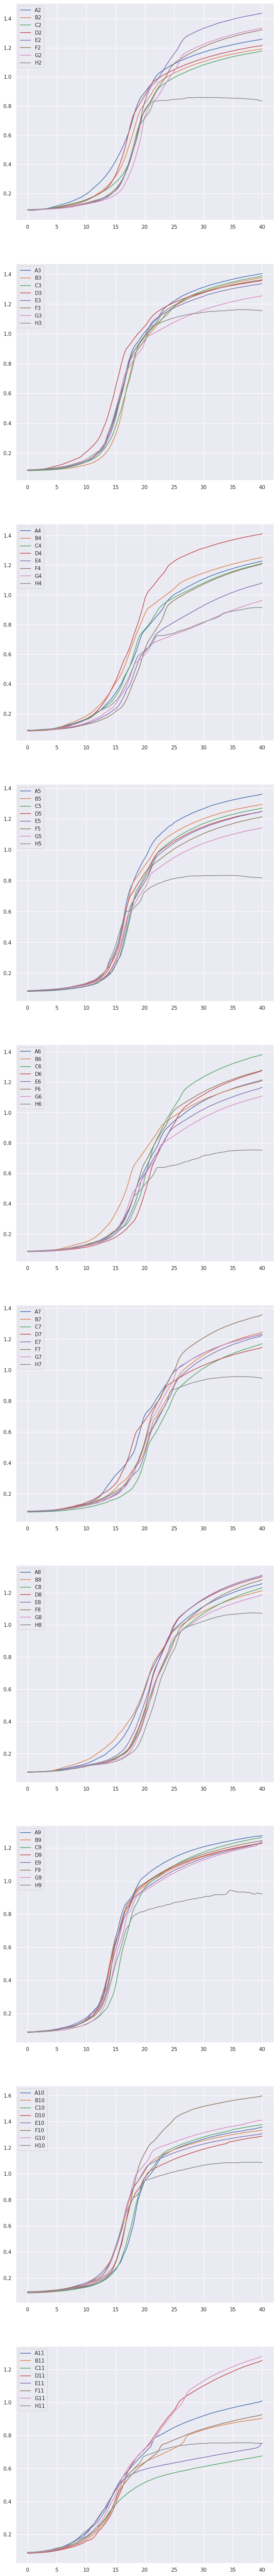

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.close('all')

fig, axs = plt.subplots(nrows = len(replicates_dic), figsize=(10,100))

i=0
xdata = data["TIME"].to_list()
for rep in replicates_dic:
    for_legend = []
    to_concat = []
    for col in replicates_dic[rep]:
        for_legend.append(col)
        ydata = data[col].to_list()
        ydata = curve_smoothing(ydata)
        ydata = curve_smoothing(ydata)
        ydata = curve_smoothing(ydata)
        axs[i].plot(xdata, ydata)
        axs[i].legend(for_legend, loc='best')
    i+=1
    
plt.show()

Identify some outliers from the curves, add them to outliers lists in Build_Experimental.py

In [9]:

outliers_20220429 = ["A2", "D2", "G2", "F2", "A3", "B3", "C3", "D3", "E3",
                    "D4", "E4", "F4", "H4", "A5", "B5", "F5", "G5", "H5", 
                    "A6", "D6", "C6", "H6", "B7", "G7", "F7", "H7", "A8",
                    "F8", "H8", "G8", "A9", "B9", "E9", "F9", "G9", "H9",
                    "A10", "G10", "H10", "F10", "B10", "F11", "H11", "A11"]
outliers_20220504 = ["E2", "F2", "G2", "H2", "E3", "F3", "G3", "H3", "A4",
                    "B4", "E4", "F4", "H4", "B5", "D5", "E5", "F5", "G5",
                    "H5", "G7", "H8", "D8", "A9", "H9", "D10", "E10", "F10",
                    "G10", "B11", "C11", "G11", "H11"]
outliers_20220506 = ["A2", "E2", "G2", "H2", "C3", "D3", "E3", "A4", "B4",
                    "C4", "F4", "A5", "B5", "C5", "G5", "H5", "C6", "G6",
                    "A7", "D7", "E7", "F7", "G7", "H7", "E8", "F8", "H8",
                    "A9", "E9", "F9", "G9"]                 
outliers_20220507 = ["B3", "C3", "D3", "E3", "H3", "G4", "H4", "A5", "B5",
                    "H5", "E5", "A6", "B6", "F6", "H6", "H7", "D8", "G8",
                    "B8","A9", "B9", "C9", "G9", "H9", "B10", "C10", "D10",
                    "E10", "A11"]
outliers_20220512 = ["A2", "B2", "F2", "D3", "H3", "F3", "G3", "C4", "G4",
                    "H4", "B5", "G5", "H5", "D6", "H6", "F7", "G7", "H7", 
                    "H8", "A9", "H9", "B11", "C11", "D11", "E11", "F11", "G11"]
outliers_20220513 = ["G2", "A3", "E3", "G3", "H3", "A4", "F4", "H4", "A5", "G5",
                    "F5", "H5", "E5", "B6", "H6", "A8", "B8", "H8", "A7", "A9",
                    "B9", "F9", "A10", "F10", "A11", "H11"]
outliers_20220514 = ["A2", "H2", "F3", "C4", "C5" "F7", "G7", "H7", "A8", "B8",
                    "C8", "D8", "E8", "C9", "H9", "F10", "G10"]
outliers_20220823 = ["C2", "A3", "D3", "F3", "G3", "H3", "A4", "D4", "E4", "F4",
                    "G4", "H4", "A5", "C5", "D6", "A7", "H7", "G7", "A8", "H8",
                    "C9", "G10", "H10", "A11", "B11", "E11", "H11"]
outliers_20220824 = ["B2", "C2", "D2", "H2", "A3", "H3", "D3", "E3", "A4", "B4",
                    "C4", "F4", "G4", "F5", "C7", "H7", "B8", "C8", "D8", "F8",
                    "D9", "C10", "B10", "A10", "F10", "C11", "E11", "F11", "G11",
                    "H11"]
outliers_20220825 = ["B2", "C2", "D2", "H2", "A3", "D3", "E3", "F3", "G3", "H3",
                    "C4", "D4", "A6", "C6", "D6", "F6", "H6", "B7", "C7", "D7",
                    "E7", "F7", "A8", "B8", "C8", "D8", "E8", "H8", "A10", "E10",
                    "F10", "G10"]
outliers_20220826 = ["G2", "H2", "C3", "D3", "E3", "F3", "H3", "A4", "B4", "E4",
                    "F4", "B5", "E5", "H5", "E6", "G6", "H6", "C7", "B8", "C8",
                    "F8", "G8", "H8", "B9", "C9", "D9", "F9",  "B10", "B11", "D11"]

outliers_dic = {"20220429":outliers_20220429, "20220504":outliers_20220504, 
                "20220506":outliers_20220506, "20220507":outliers_20220507,
                "20220512":outliers_20220512, "20220513":outliers_20220513,
                "20220514":outliers_20220514, "20220823":outliers_20220823, 
                "20220824":outliers_20220824, "20220825":outliers_20220825,
                "20220826":outliers_20220826}


In [10]:
out = outliers_dic[run_name]
out

['G2',
 'H2',
 'C3',
 'D3',
 'E3',
 'F3',
 'H3',
 'A4',
 'B4',
 'E4',
 'F4',
 'B5',
 'E5',
 'H5',
 'E6',
 'G6',
 'H6',
 'C7',
 'B8',
 'C8',
 'F8',
 'G8',
 'H8',
 'B9',
 'C9',
 'D9',
 'F9',
 'B10',
 'B11',
 'D11']

Fill up the 'start_stop' file manually

In [11]:
start_stop = pd.read_csv('Dataset_experimental/' + run_name + '_start_stop.csv', index_col=0, sep=",")
start_stop

,A1,B1,C1,D1,E1,F1,G1,H1,A2,B2,...,G11,H11,A12,B12,C12,D12,E12,F12,G12,H12
start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Compute all maximal growth rates

In [12]:
WINDOW_SIZE = 6
def growth_rate_determination(data, outliers, start_stop):
    # data: dataframe containing all raw data
    # out: outliers list, concerned wells will be ignored (pd.NA values)
    # start_stop: dataframe giving the starting and stopping points for the
    # maximum growth rate search
    # returns all the growth rates of the plate run, as a list of lists

    all_grs = []

    for plates in replicates_dic.values():
        grs = []
        for pl in plates:
            if pl not in outliers:
                
                xdata = data["TIME"].to_list()
                ydata = data[pl].to_list()

                # smoothing
                for _ in range(4):
                    ydata = curve_smoothing(ydata)


                start = start_stop[pl][0]
                if pd.isna(start):
                    start = 0
                stop = start_stop[pl][1]
                if pd.isna(stop):
                    stop = data["TIME"].iloc[-1]

                start_ind = int(start*6)
                stop_ind = int(stop*6)

                xdata = xdata[start_ind:stop_ind]
                ydata = ydata[start_ind:stop_ind]
                
                win_size = WINDOW_SIZE
                all_polyfit_grs = [np.polyfit(xdata[i:i+win_size], np.log(ydata[i:i+win_size]), 1)[0] for i in range(len(xdata)-win_size)]
                
                grs.append(max(all_polyfit_grs)) 
            else:
                
                grs.append(pd.NA)
        all_grs.append(grs)

    return all_grs

In [13]:
all_grs = growth_rate_determination(data, out, start_stop)
gr_df = pd.DataFrame(all_grs, columns = ["GR_" +str(i) for i in range(1,9)])
gr_df

,GR_1,GR_2,GR_3,GR_4,GR_5,GR_6,GR_7,GR_8
0,0.20245,0.247148,0.298453,0.290705,0.299738,0.300215,<NA>,<NA>
1,0.369287,0.370988,<NA>,<NA>,<NA>,<NA>,0.395089,<NA>
2,<NA>,<NA>,0.231091,0.218677,<NA>,<NA>,0.248761,0.229897
3,0.357842,<NA>,0.372467,0.373017,<NA>,0.372673,0.361427,<NA>
4,0.260221,0.241647,0.281107,0.286537,<NA>,0.286689,<NA>,<NA>
5,0.254874,0.245461,<NA>,0.267864,0.26812,0.25183,0.281674,0.256935
6,0.200915,<NA>,<NA>,0.279072,0.260733,<NA>,<NA>,<NA>
7,0.382175,<NA>,<NA>,<NA>,0.400052,<NA>,0.436497,0.352992
8,0.341575,<NA>,0.340986,0.416754,0.342987,0.383552,0.356544,0.358787
9,0.192927,<NA>,0.16392,<NA>,0.206822,0.218777,0.204666,0.182186


Add the average and standard deviation, save the dataset

In [14]:
compositions_w_grs = pd.concat([compositions, gr_df.set_index(compositions.index)], axis=1)
compositions_w_grs['GR_AVG'] = compositions_w_grs[["GR_" +str(i) for i in range(1,9)]].mean(axis=1)
compositions_w_grs['GR_STD'] = compositions_w_grs[["GR_" +str(i) for i in range(1,9)]].std(axis=1)
compositions_w_grs.to_csv("Dataset_experimental/" + run_name + "_results.csv", index=True)
compositions_w_grs

,EX_rib__D_e_i,EX_malt_e_i,EX_melib_e_i,EX_tre_e_i,EX_fru_e_i,EX_gal_e_i,EX_ac_e_i,EX_lac__D_e_i,EX_succ_e_i,EX_pyr_e_i,GR_1,GR_2,GR_3,GR_4,GR_5,GR_6,GR_7,GR_8,GR_AVG,GR_STD
31,1,0,0,0,1,1,0,1,0,0,0.20245,0.247148,0.298453,0.290705,0.299738,0.300215,<NA>,<NA>,0.273118,0.040156
32,1,1,0,1,0,1,0,0,0,0,0.369287,0.370988,<NA>,<NA>,<NA>,<NA>,0.395089,<NA>,0.378455,0.014431
33,1,1,1,0,0,0,0,0,0,1,<NA>,<NA>,0.231091,0.218677,<NA>,<NA>,0.248761,0.229897,0.232106,0.012431
34,1,1,0,0,1,0,0,0,1,0,0.357842,<NA>,0.372467,0.373017,<NA>,0.372673,0.361427,<NA>,0.367485,0.007281
35,1,0,0,1,0,0,1,1,0,0,0.260221,0.241647,0.281107,0.286537,<NA>,0.286689,<NA>,<NA>,0.271240,0.019794
36,0,0,1,0,0,1,1,1,0,0,0.254874,0.245461,<NA>,0.267864,0.26812,0.25183,0.281674,0.256935,0.260965,0.012280
37,1,0,1,0,1,0,0,1,0,0,0.200915,<NA>,<NA>,0.279072,0.260733,<NA>,<NA>,<NA>,0.246907,0.040872
38,0,1,1,1,0,0,0,0,1,0,0.382175,<NA>,<NA>,<NA>,0.400052,<NA>,0.436497,0.352992,0.392929,0.034926
39,0,1,1,1,1,0,0,0,0,0,0.341575,<NA>,0.340986,0.416754,0.342987,0.383552,0.356544,0.358787,0.363026,0.028034
40,0,0,0,0,1,0,0,1,1,1,0.192927,<NA>,0.16392,<NA>,0.206822,0.218777,0.204666,0.182186,0.194883,0.019661


## Example of the data processing workflow for all plates 
Now, a full processing for all plates in a single cell

In [15]:
all_plates = ["20220504", "20220429", "20220506", "20220507", "20220512", "20220513", "20220514", '20220823', '20220824', '20220825', '20220826']
for run_name in all_plates:
    run_raw_data_path = "Dataset_experimental/"+run_name+"_data.csv"
    data = pd.read_csv(run_raw_data_path, sep=",")

    composition = create_composition_file(run_name)
    # run_dict = dict_all[run_name] # this mapping is stored in the python file 'Build_Experimental.py'. More details there.
    # compositions = pd.read_csv(run_dict["DoE_file"], index_col=0, sep=",").iloc[run_dict["indices"][0]:run_dict["indices"][1]]
    # compositions.to_csv('Dataset_experimental/' + run_name + '_compos.csv')
    
    out = outliers_dic[run_name]
    start_stop = pd.read_csv('Dataset_experimental/' + run_name + '_start_stop.csv', index_col=0, sep=",")
    all_grs = growth_rate_determination(data, out, start_stop)
    gr_df = pd.DataFrame(all_grs, columns = ["GR_" +str(i) for i in range(1,9)])
    compositions_w_grs = pd.concat([compositions, gr_df.set_index(compositions.index)], axis=1)
    compositions_w_grs['GR_AVG'] = compositions_w_grs[["GR_" +str(i) for i in range(1,9)]].mean(axis=1)
    compositions_w_grs['GR_STD'] = compositions_w_grs[["GR_" +str(i) for i in range(1,9)]].std(axis=1)
    compositions_w_grs.to_csv("Dataset_experimental/" + run_name + "_results.csv", index=True)

## Merge all results file in a single .csv file

In [16]:
runs_to_concat = ["20220504", "20220429", "20220506", "20220507", "20220512", "20220513", "20220514", '20220823', '20220824', '20220825', '20220826']
index_cols = [0 for i in runs_to_concat]
folder = "Dataset_experimental/"
training_set_filename = "EXP110.csv"
results_to_concat = []

for run_name in runs_to_concat:
    results_f = folder + run_name + '_results.csv'
    results = pd.read_csv(results_f, index_col=index_cols[runs_to_concat.index(run_name)])
    results_to_concat.append(results)
    
training_set_df = pd.concat(results_to_concat, ignore_index=True)
training_set_df

,EX_rib__D_e_i,EX_malt_e_i,EX_melib_e_i,EX_tre_e_i,EX_fru_e_i,EX_gal_e_i,EX_ac_e_i,EX_lac__D_e_i,EX_succ_e_i,EX_pyr_e_i,GR_1,GR_2,GR_3,GR_4,GR_5,GR_6,GR_7,GR_8,GR_AVG,GR_STD
0,1,0,0,0,1,1,0,1,0,0,0.169077,0.158486,0.161497,0.189294,NaN,NaN,NaN,NaN,0.169588,0.013872
1,1,1,0,1,0,1,0,0,0,0,0.112542,0.137510,0.161887,0.124116,NaN,NaN,NaN,NaN,0.134014,0.021199
2,1,1,1,0,0,0,0,0,0,1,NaN,NaN,0.184592,0.182140,NaN,NaN,0.198978,NaN,0.188570,0.009096
3,1,1,0,0,1,0,0,0,1,0,0.234978,NaN,0.162976,NaN,NaN,NaN,NaN,NaN,0.198977,0.050913
4,1,0,0,1,0,0,1,1,0,0,0.067542,0.070027,0.077356,0.076734,0.064198,0.061576,0.082361,0.076108,0.071988,0.007257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,1,0,0,1,1,1,0,0,0.254874,0.245461,NaN,0.267864,0.268120,0.251830,0.281674,0.256935,0.260965,0.012280
106,1,0,1,0,1,0,0,1,0,0,0.200915,NaN,NaN,0.279072,0.260733,NaN,NaN,NaN,0.246907,0.040872
107,0,1,1,1,0,0,0,0,1,0,0.382175,NaN,NaN,NaN,0.400052,NaN,0.436497,0.352992,0.392929,0.034926
108,0,1,1,1,1,0,0,0,0,0,0.341575,NaN,0.340986,0.416754,0.342987,0.383552,0.356544,0.358787,0.363026,0.028034


In [19]:
training_set_df.to_csv(folder+training_set_filename)